In [1]:
import sys
sys.path.append("../") # adding the path to read the utils file
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn import metrics, tree
from shap import TreeExplainer
import fasttreeshap
from shap import plots, Explanation
import graphviz 
from yellowbrick.model_selection import LearningCurve
import time
import shap
from utils import *
import pickle
import glob
from interpret import show, preserve
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap
from memory_profiler import memory_usage

pd.set_option('display.max_columns', None)

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = pd.concat([pd.read_csv(csv_file, engine='pyarrow', index_col='id') for csv_file in glob.glob('../datasets/NFS-2023-TE/*.csv')], ignore_index=True)
ds.head()

,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,protocol,ip_version,vlan_id,bidirectional_first_seen_ms,bidirectional_last_seen_ms,bidirectional_duration_ms,bidirectional_packets,bidirectional_bytes,src2dst_first_seen_ms,src2dst_last_seen_ms,src2dst_duration_ms,src2dst_packets,src2dst_bytes,dst2src_first_seen_ms,dst2src_last_seen_ms,dst2src_duration_ms,dst2src_packets,dst2src_bytes,bidirectional_min_ps,bidirectional_mean_ps,bidirectional_stddev_ps,bidirectional_max_ps,src2dst_min_ps,src2dst_mean_ps,src2dst_stddev_ps,src2dst_max_ps,dst2src_min_ps,dst2src_mean_ps,dst2src_stddev_ps,dst2src_max_ps,bidirectional_min_piat_ms,bidirectional_mean_piat_ms,bidirectional_stddev_piat_ms,bidirectional_max_piat_ms,src2dst_min_piat_ms,src2dst_mean_piat_ms,src2dst_stddev_piat_ms,src2dst_max_piat_ms,dst2src_min_piat_ms,dst2src_mean_piat_ms,dst2src_stddev_piat_ms,dst2src_max_piat_ms,bidirectional_syn_packets,bidirectional_cwr_packets,bidirectional_ece_packets,bidirectional_urg_packets,bidirectional_ack_packets,bidirectional_psh_packets,bidirectional_rst_packets,bidirectional_fin_packets,src2dst_syn_packets,src2dst_cwr_packets,src2dst_ece_packets,src2dst_urg_packets,src2dst_ack_packets,src2dst_psh_packets,src2dst_rst_packets,src2dst_fin_packets,dst2src_syn_packets,dst2src_cwr_packets,dst2src_ece_packets,dst2src_urg_packets,dst2src_ack_packets,dst2src_psh_packets,dst2src_rst_packets,dst2src_fin_packets,label
0,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1031,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835357,1499428835358,1,6,800,1499428835357,1499428835358,1,4,473,1499428835357,1499428835358,1,2,327,60,133.333333,109.302638,287,60,118.25,112.535550,287,66,163.5,137.885822,261,0,0.200000,0.447214,1,0,0.333333,0.57735,1,1,1.0,0.000000,1,2,0,0,0,5,2,0,1,1,0,0,0,3,1,0,1,1,0,0,0,2,1,0,0,BENIGN
1,-1,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1031,6,4,0,1499428835358,1499428835358,0,2,120,1499428835358,1499428835358,0,2,120,0,0,0,0,0,60,60.000000,0.000000,60,60,60.00,0.000000,60,0,0.0,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,0.000000,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,BENIGN
2,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1032,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835374,1499428835375,1,7,2265,1499428835374,1499428835375,1,5,613,1499428835374,1499428835375,1,2,1652,60,323.571429,568.141372,1586,60,122.60,136.648454,367,66,826.0,1074.802307,1586,0,0.166667,0.408248,1,0,0.250000,0.50000,1,1,1.0,0.000000,1,2,0,0,0,6,2,0,1,1,0,0,0,4,1,0,1,1,0,0,0,2,1,0,0,BENIGN
3,-1,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1032,6,4,0,1499428835375,1499428835375,0,2,120,1499428835375,1499428835375,0,2,120,0,0,0,0,0,60,60.000000,0.000000,60,60,60.00,0.000000,60,0,0.0,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.00000,0,0,0.0,0.000000,0,0,0,0,0,2,0,1,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,BENIGN
4,-1,192.168.10.9,b8:ac:6f:1d:1f:6c,b8:ac:6f,1033,192.168.10.3,18:66:da:9b:e3:7d,18:66:da,88,6,4,0,1499428835416,1499428835417,1,8,3550,1499428835416,1499428835417,1,5,1852,1499428835416,1499428835417,1,3,1698,60,443.750000,706.926901,1606,60,370.40,690.726284,1606,60,566.0,871.226721,1572,0,0.142857,0.377964,1,0,0.250000,0.50000,1,0,0.5,0.707107,1,2,0,0,0,7,2,0,1,1,0,0,0,4,1,0,1,1,0,0,0,3,1,0,0,BENIGN


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153360 entries, 0 to 3153359
Data columns (total 76 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   expiration_id                 int64  
 1   src_ip                        object 
 2   src_mac                       object 
 3   src_oui                       object 
 4   src_port                      int64  
 5   dst_ip                        object 
 6   dst_mac                       object 
 7   dst_oui                       object 
 8   dst_port                      int64  
 9   protocol                      int64  
 10  ip_version                    int64  
 11  vlan_id                       int64  
 12  bidirectional_first_seen_ms   int64  
 13  bidirectional_last_seen_ms    int64  
 14  bidirectional_duration_ms     int64  
 15  bidirectional_packets         int64  
 16  bidirectional_bytes           int64  
 17  src2dst_first_seen_ms         int64  
 18  src2dst_last_seen_ms  

In [4]:
compute_ratio(ds,'label')

                            Ratio
label                            
BENIGN                      83.71
PortScan                     7.34
DoS Hulk                     5.03
DDoS                         3.03
FTP-Patator                  0.25
DoS GoldenEye                0.25
DoS slowloris                0.16
SSH-Patator                  0.09
DoS Slowhttptest             0.09
Bot                          0.02
Web Attack - Brute Force     0.00
Infiltration                 0.00
Web Attack - XSS             0.00
Web Attack - Sql Injection   0.00
Heartbleed                   0.00


In [5]:
ds.label.value_counts()

label
BENIGN                        2639806
PortScan                       231572
DoS Hulk                       158546
DDoS                            95685
FTP-Patator                      7963
DoS GoldenEye                    7917
DoS slowloris                    5192
SSH-Patator                      2980
DoS Slowhttptest                 2732
Bot                               738
Web Attack - Brute Force          151
Infiltration                       28
Web Attack - XSS                   27
Web Attack - Sql Injection         12
Heartbleed                         11
Name: count, dtype: int64

In [6]:
ds = ds.drop(columns=feature_to_remove_NFS)

In [7]:
sample_weights = ds.label.value_counts().to_dict()

In [8]:
sample_weights['BENIGN'] = 738
sample_weights['PortScan'] = 738
sample_weights['DoS Hulk'] = 738
sample_weights['DDoS'] = 738
sample_weights['FTP-Patator'] = 738
sample_weights['DoS GoldenEye'] = 738
sample_weights['DoS slowloris'] = 738
sample_weights['SSH-Patator'] = 738
sample_weights['DoS Slowhttptest'] = 738

In [9]:
params = {
    'learning_rate': 1,
}

ebm = ExplainableBoostingClassifier()

rus = RandomUnderSampler(random_state=42, sampling_strategy=sample_weights)
X_res, y_res = rus.fit_resample(ds.drop(columns=['label']), ds['label'])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state=12, shuffle=True, stratify=y_res)

In [11]:
if False:
    cv = 5
    visualizer = LearningCurve(estimator=ebm, cv=cv, scoring='f1_weighted', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="ebm_data/learning_curve.png")


![Alt text](emb_data/learning_curve.png)

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf.get_n_splits(X_res, y_res)

5

In [13]:
avg_train_f1 = []
avg_test_f1 = []

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    print(f"Fold {i}:")
    ebm.fit(X_res.iloc[train_index], y_res.iloc[train_index])
    y_predicted_train = ebm.predict(X_res.iloc[train_index])
    y_predicted_test = ebm.predict(X_res.iloc[test_index])
    train_f1 = metrics.f1_score(y_res.iloc[train_index], y_predicted_train, average='macro')
    test_f1 = metrics.f1_score(y_res.iloc[test_index], y_predicted_test, average='macro')
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    avg_train_f1.append(train_f1)
    avg_test_f1.append(test_f1)

print(f"Average Train F1: {np.mean(avg_train_f1):.4f}")
print(f"Average Test F1: {np.mean(avg_test_f1):.4f}")

Fold 0:


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel

Train F1: 0.9816
Test F1: 0.9559
Fold 1:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9756
Test F1: 0.9802
Fold 2:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9816
Test F1: 0.9402
Fold 3:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9816
Test F1: 0.9499
Fold 4:


Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


Train F1: 0.9804
Test F1: 0.9747
Average Train F1: 0.9802
Average Test F1: 0.9602


In [14]:
%time ebm.fit(X_train, y_train)

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.


CPU times: user 875 ms, sys: 175 ms, total: 1.05 s
Wall time: 1min 16s


ExplainableBoostingClassifier()

In [15]:
%time y_predicted_train = ebm.predict(X_train)
%timeit ebm.predict(X_test)
y_predicted_test = ebm.predict(X_test)

CPU times: user 23.4 ms, sys: 1.33 ms, total: 24.7 ms
Wall time: 23 ms
6.61 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
memory_usage((ebm.predict, (X_test,), {}), max_usage=True)

3741.296875

In [17]:
performanceMetricsDFWeighted(metrics, y_train, y_predicted_train, y_test, y_predicted_test, 'macro')

,Measure,Train,Test
0,ACCURACY,0.975029,0.967148
1,PRECISION,0.983871,0.975634
2,RECALL,0.979490,0.916965
3,F1 SCORE,0.981038,0.938384


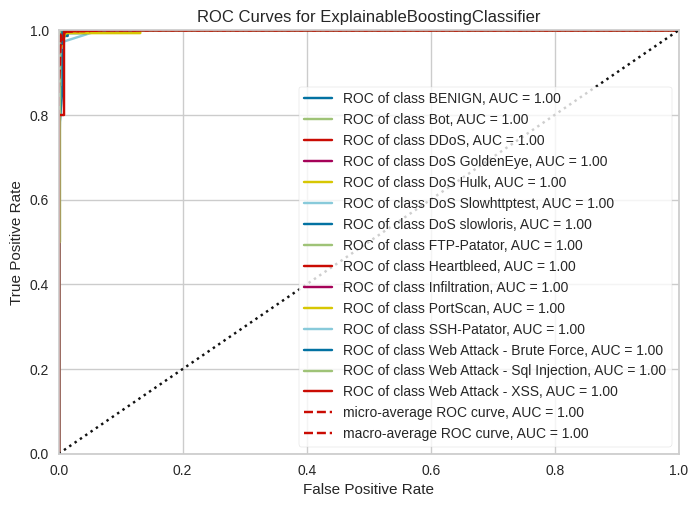

<Axes: title={'center': 'ROC Curves for ExplainableBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
model = wrap(ebm)
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

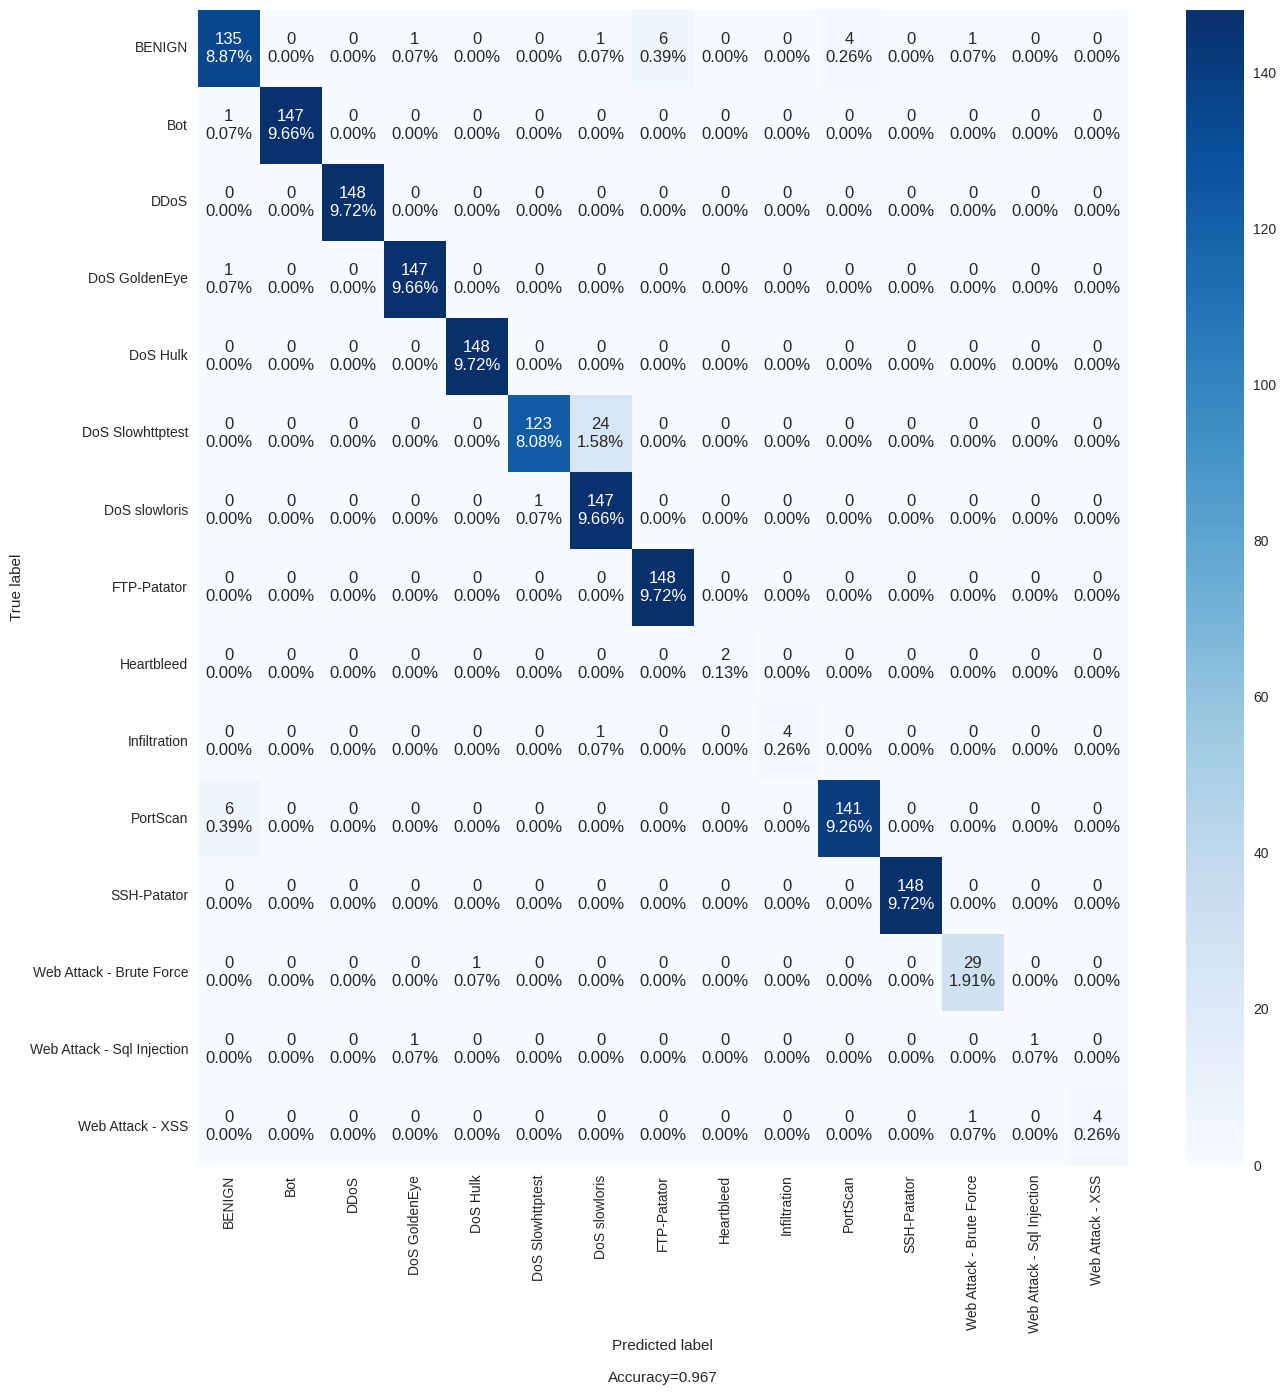

In [19]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(ebm.classes_)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [20]:
show(ebm.explain_global())

<!-- http://127.0.0.1:7001/139661961079952/ -->

In [21]:
preserve(ebm.explain_global())

## Zero day test

In [22]:
classes = sorted(pd.unique(ds['label']).tolist())

In [23]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Bot']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.971985,0.869908
1,PRECISION,0.973635,0.824089
2,RECALL,0.971985,0.869908
3,F1 SCORE,0.971824,0.838664


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



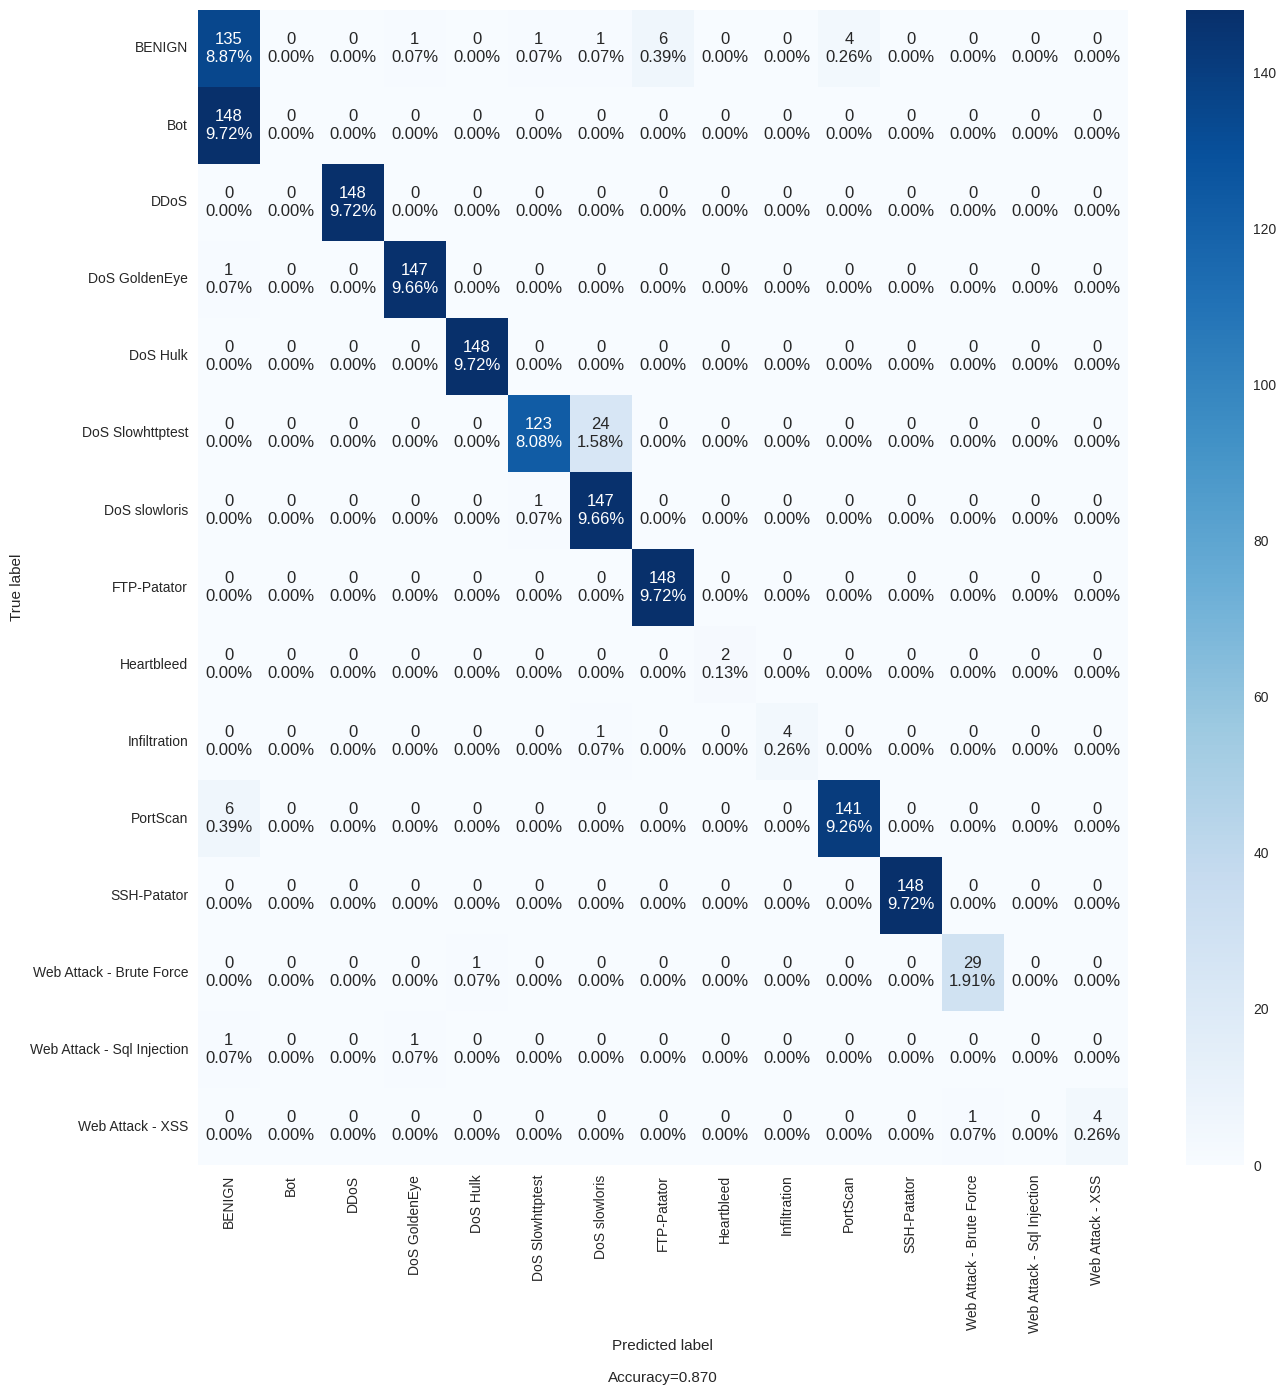

In [24]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [25]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DDoS']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.971985,0.869251
1,PRECISION,0.973637,0.822009
2,RECALL,0.971985,0.869251
3,F1 SCORE,0.971829,0.836210


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



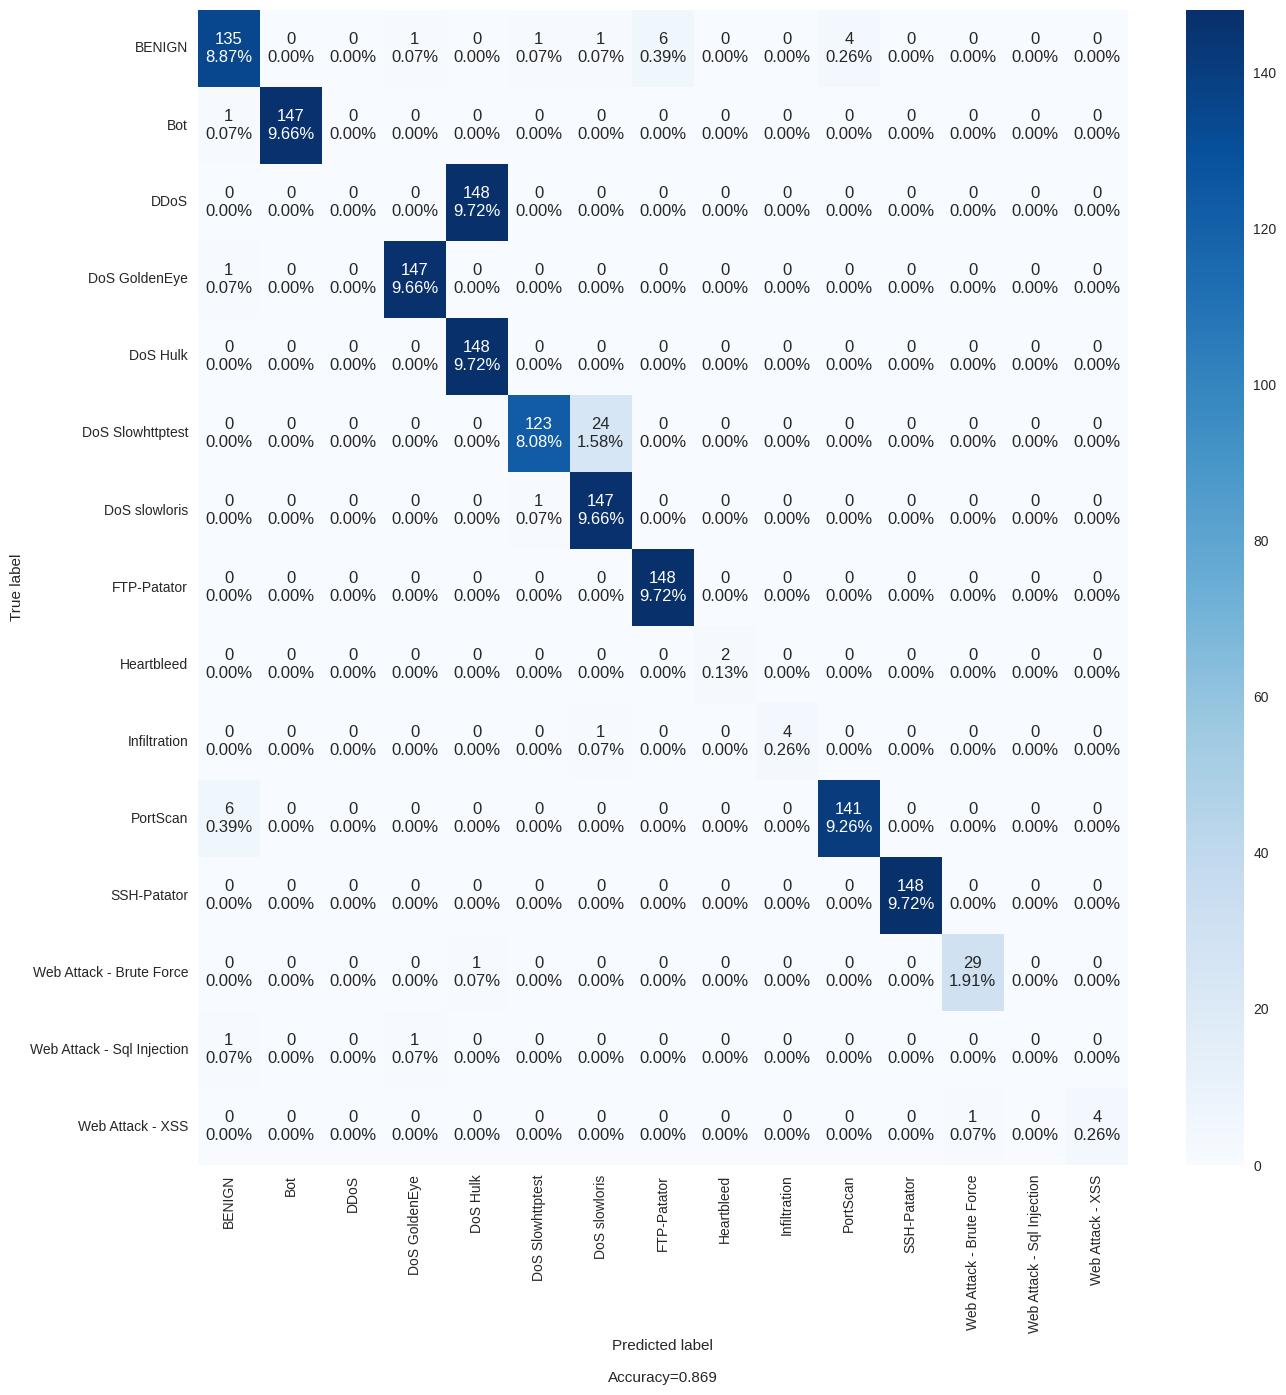

In [26]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [27]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS GoldenEye']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.975623,0.873850
1,PRECISION,0.977319,0.830453
2,RECALL,0.975623,0.873850
3,F1 SCORE,0.975565,0.845448


/tmp/ipykernel_191651/1563505262.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



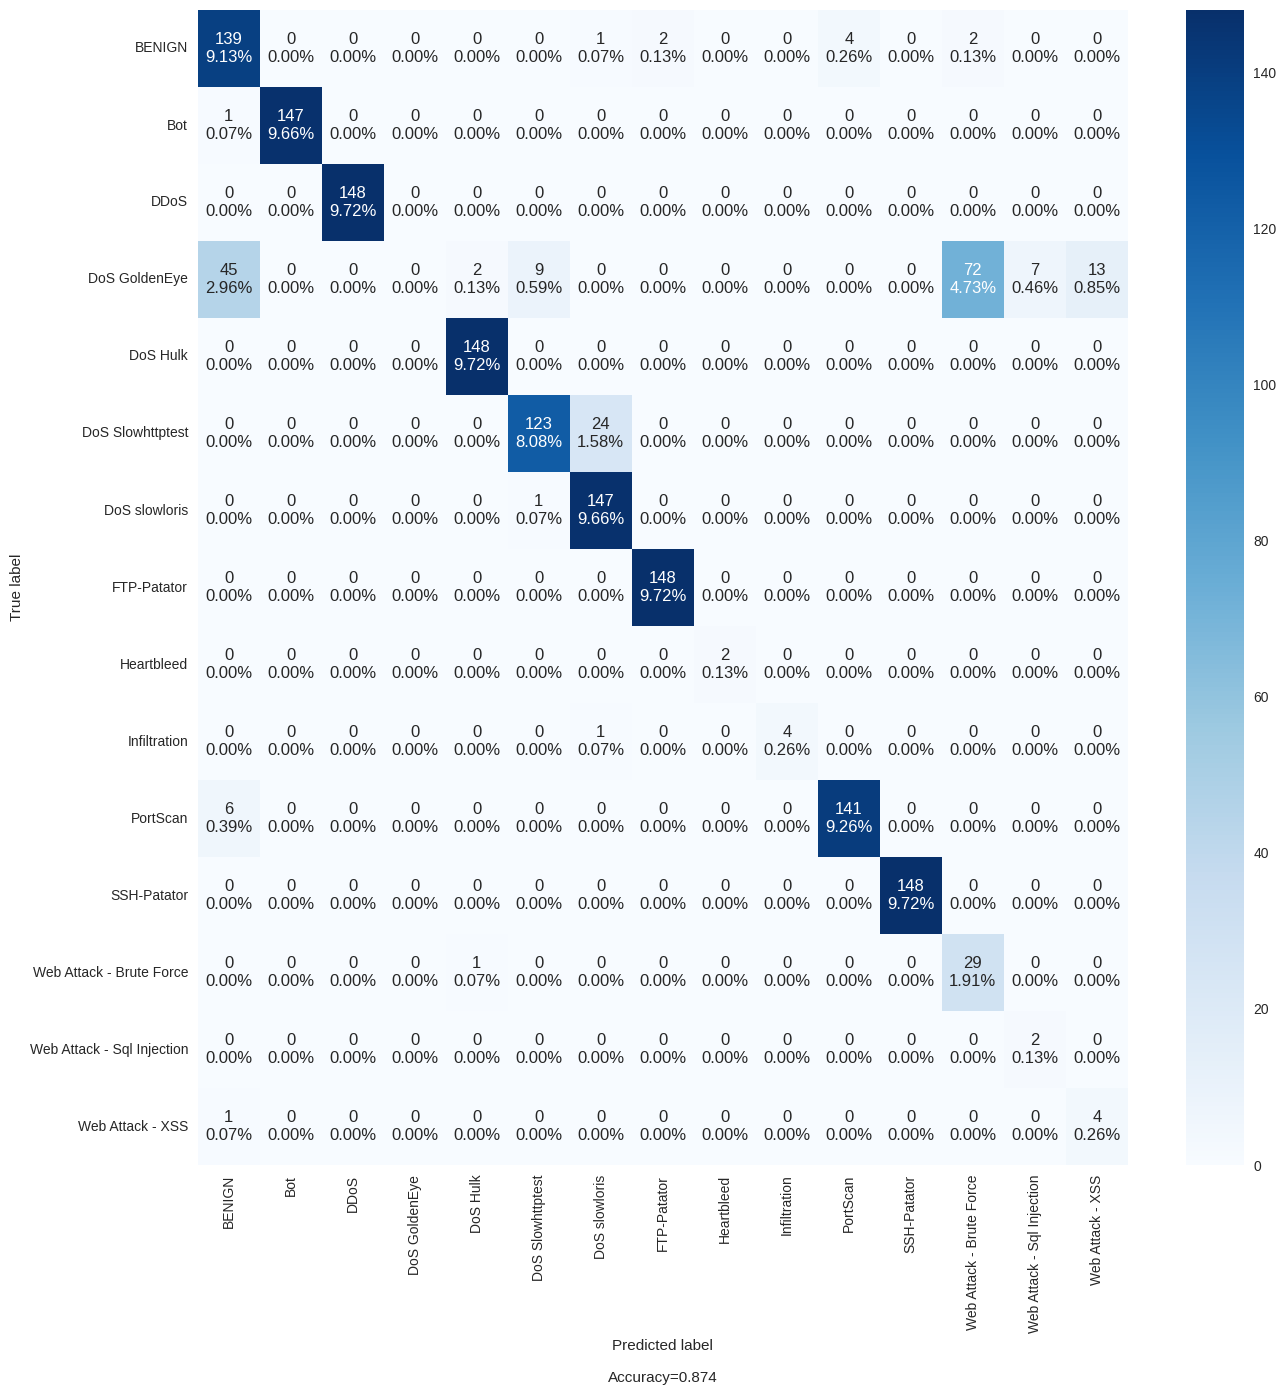

In [28]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf,
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [29]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS Hulk']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.972349,0.870565
1,PRECISION,0.974002,0.822453
2,RECALL,0.972349,0.870565
3,F1 SCORE,0.972200,0.837225


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



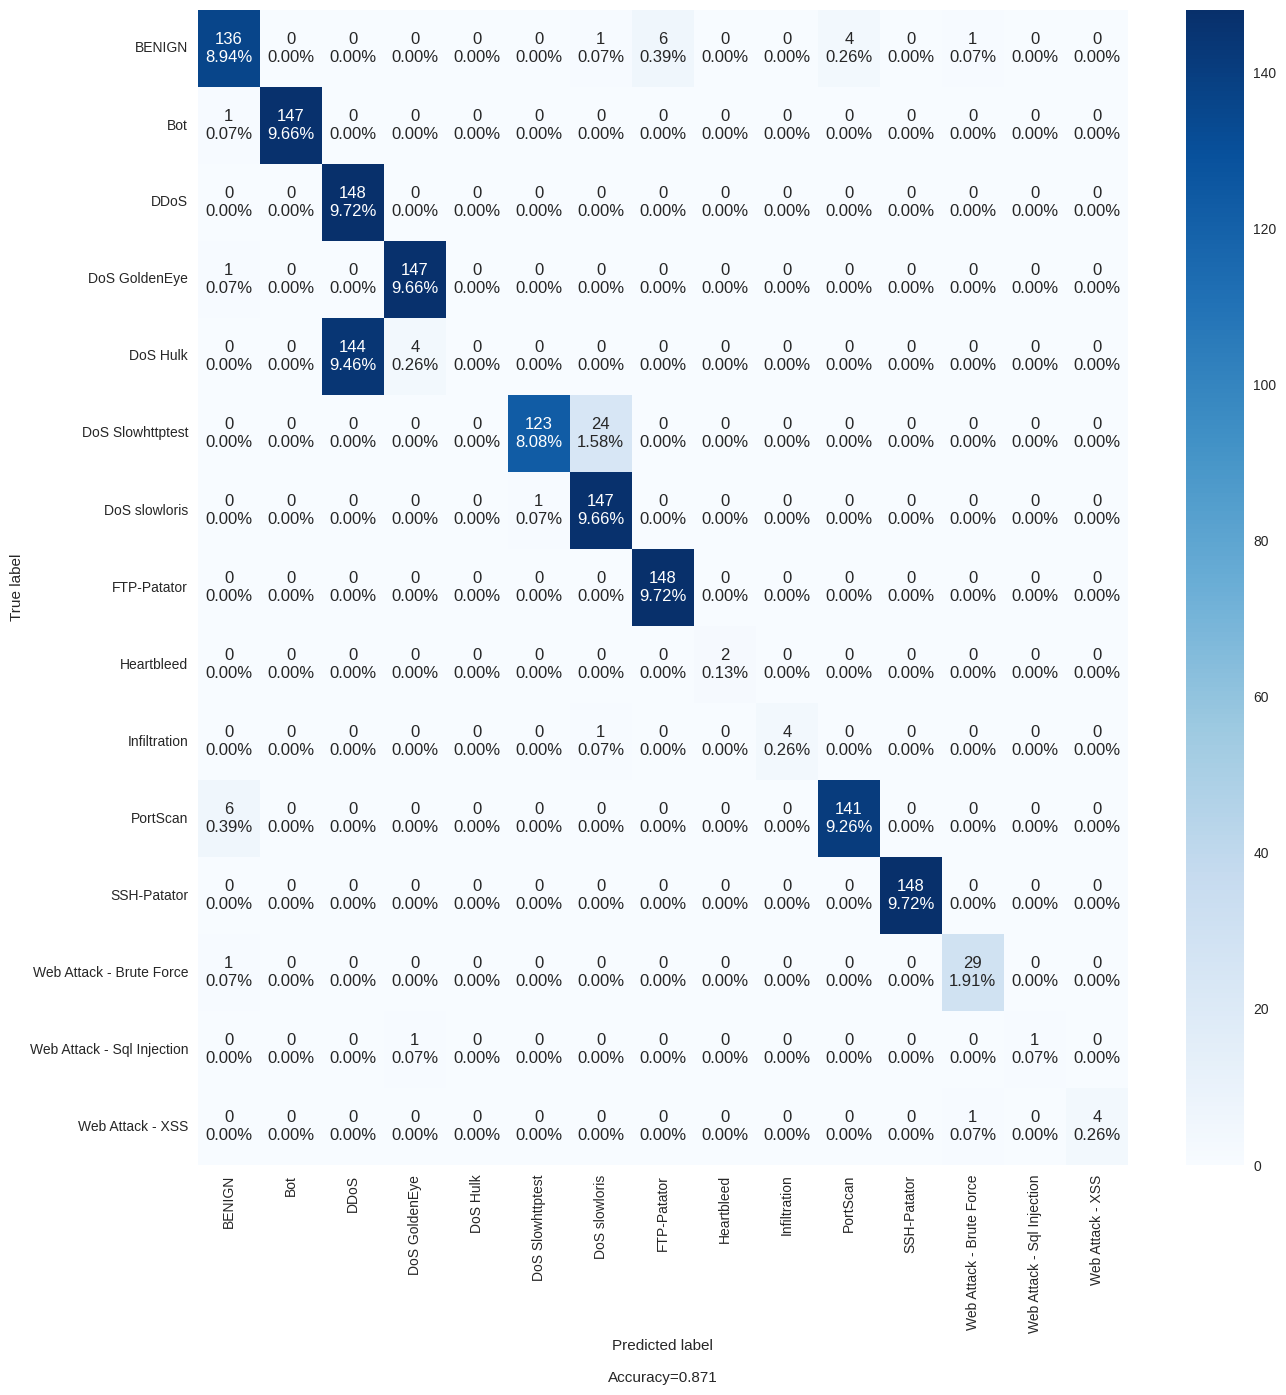

In [30]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [31]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS Slowhttptest']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.989083,0.886991
1,PRECISION,0.989074,0.835021
2,RECALL,0.989083,0.886991
3,F1 SCORE,0.989047,0.853229


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



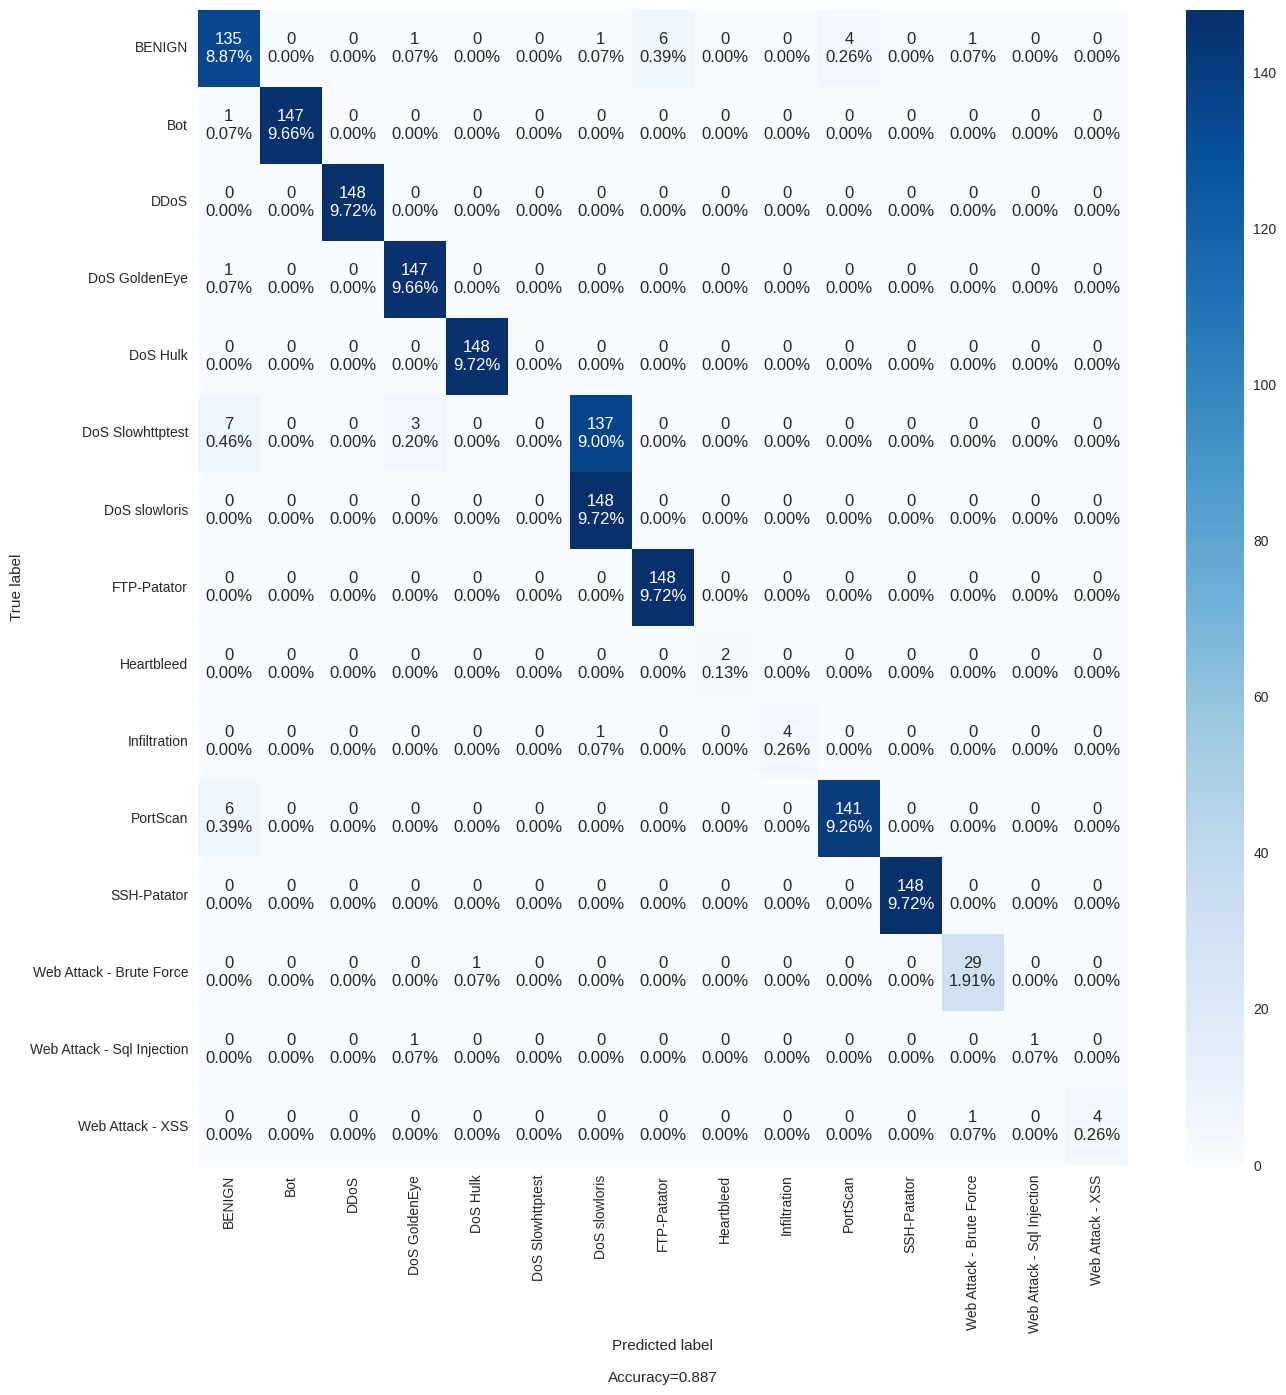

In [32]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [33]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'DoS slowloris']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.987266,0.886991
1,PRECISION,0.987252,0.839057
2,RECALL,0.987266,0.886991
3,F1 SCORE,0.987226,0.854598


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



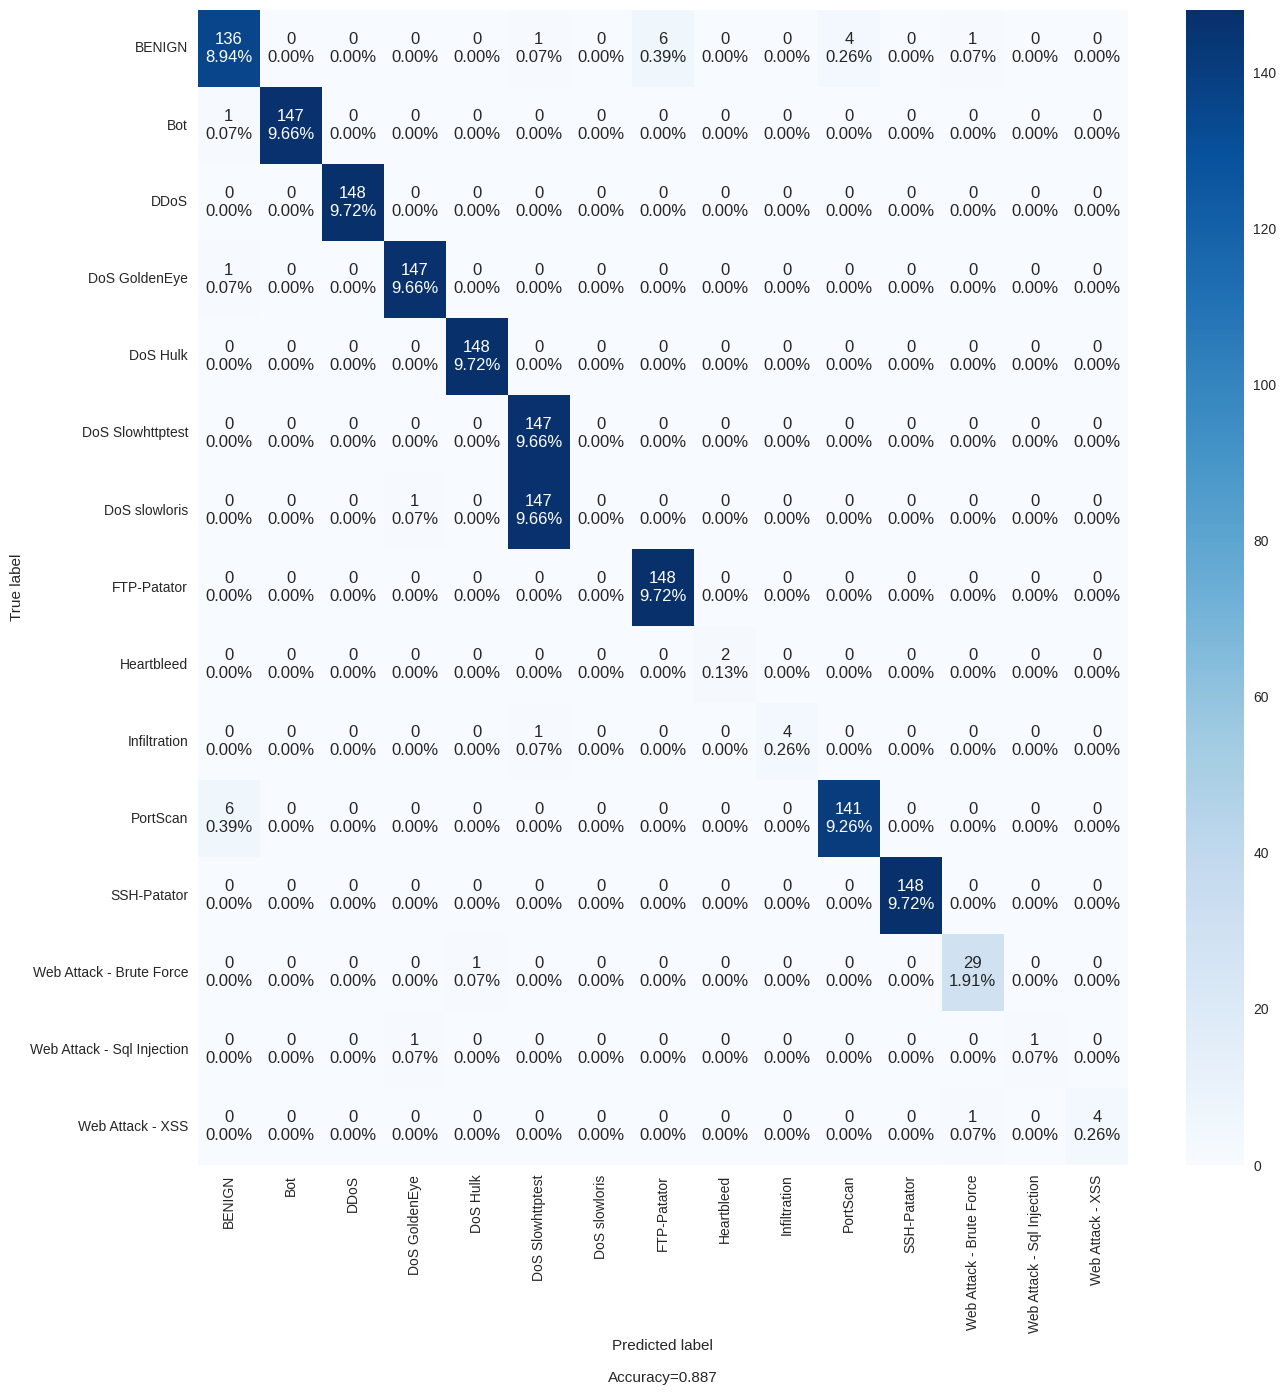

In [34]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [35]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'FTP-Patator']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.975259,0.874507
1,PRECISION,0.976939,0.807641
2,RECALL,0.975259,0.874507
3,F1 SCORE,0.975143,0.834317


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



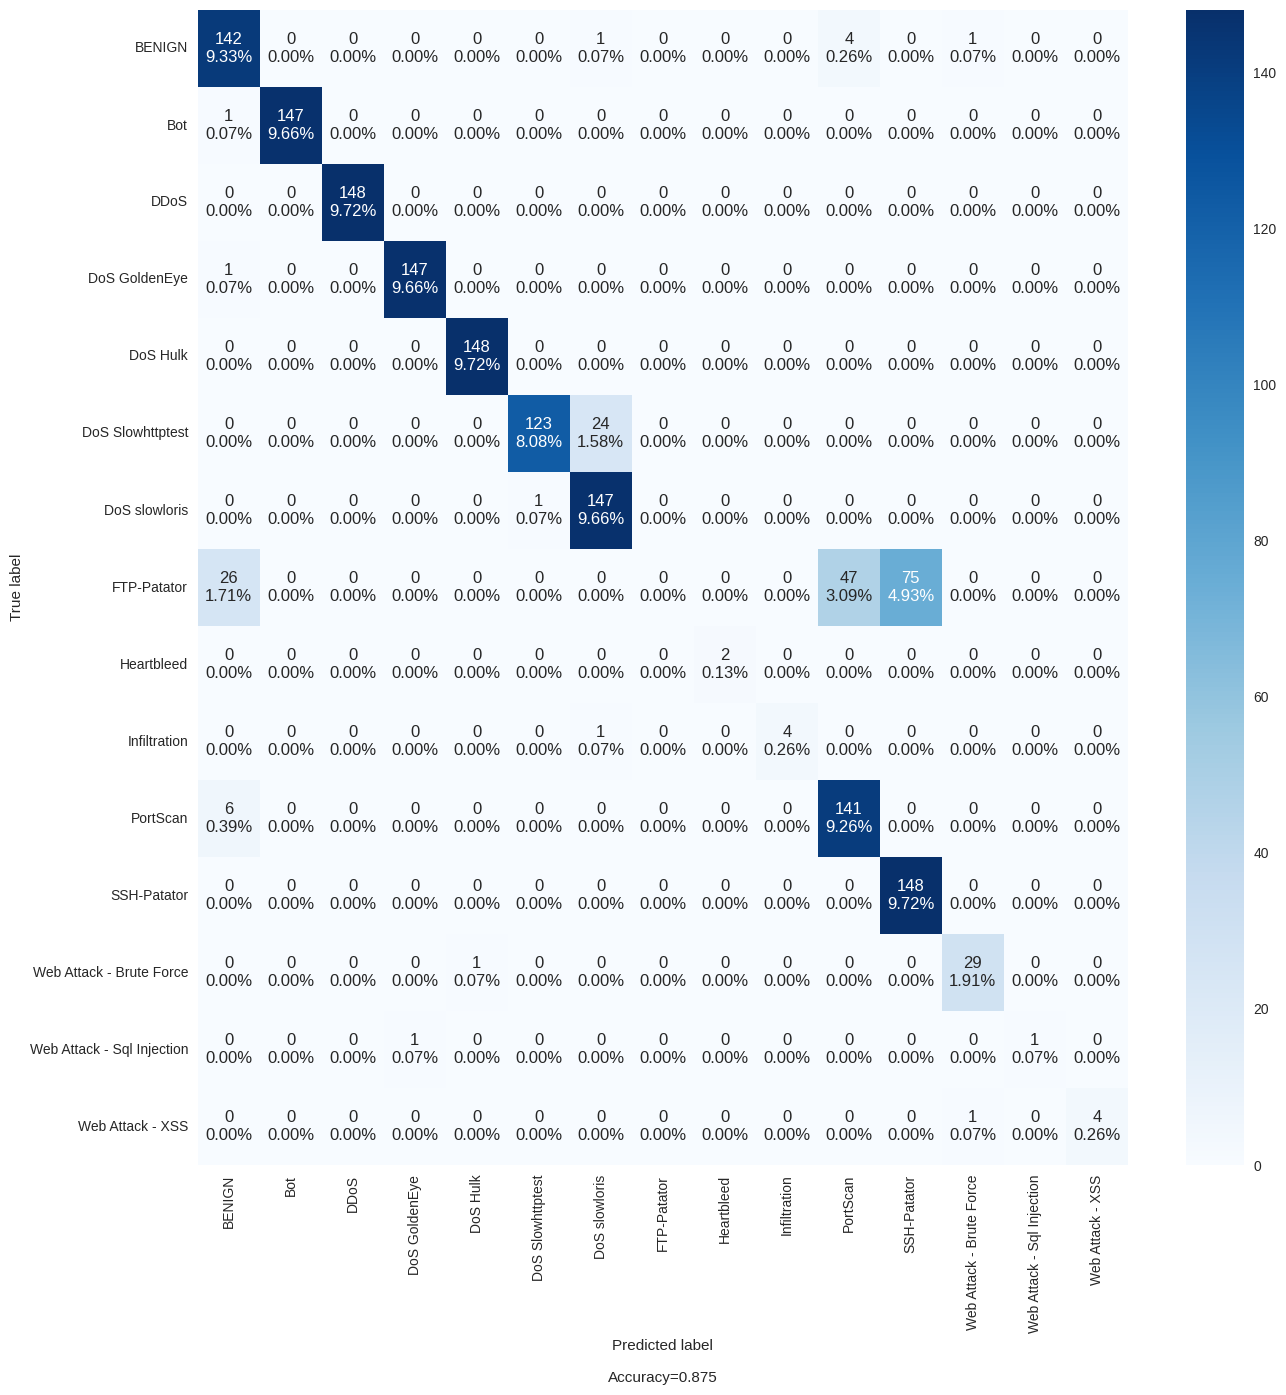

In [36]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [37]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Heartbleed']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.977789,0.971091
1,PRECISION,0.979441,0.972246
2,RECALL,0.977789,0.971091
3,F1 SCORE,0.977731,0.970346


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



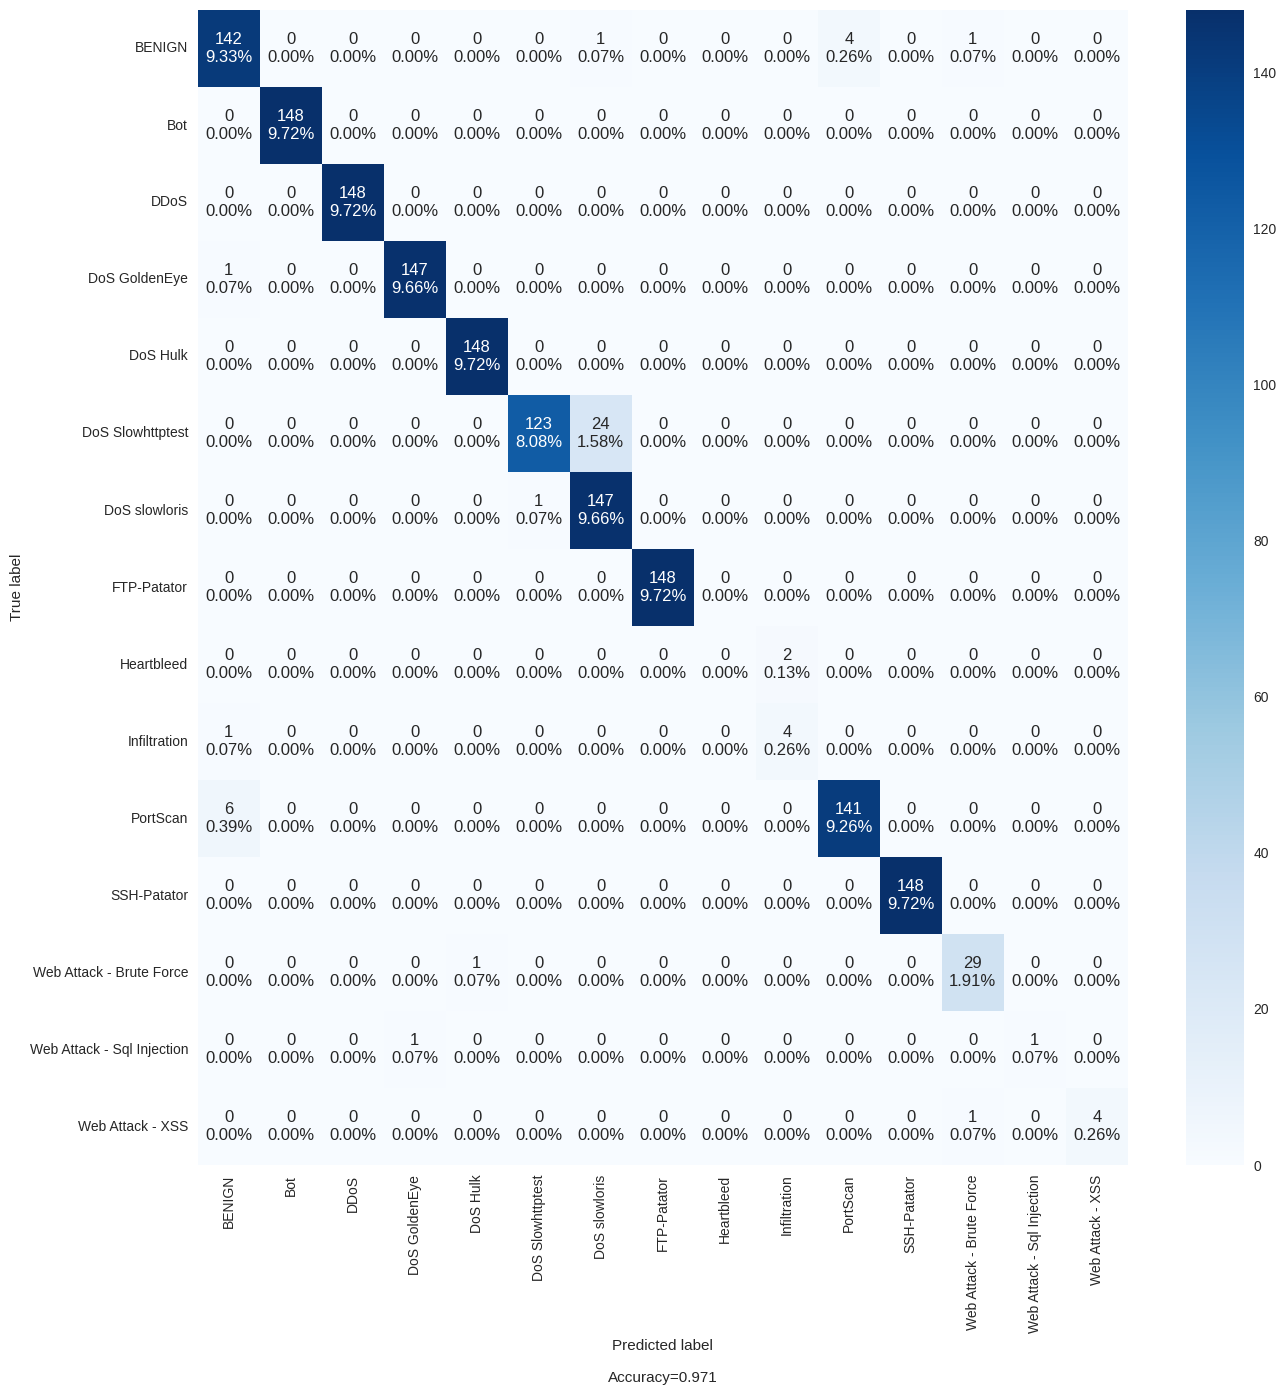

In [38]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [39]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Infiltration']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.974604,0.965177
1,PRECISION,0.976100,0.964403
2,RECALL,0.974604,0.965177
3,F1 SCORE,0.974465,0.963415


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



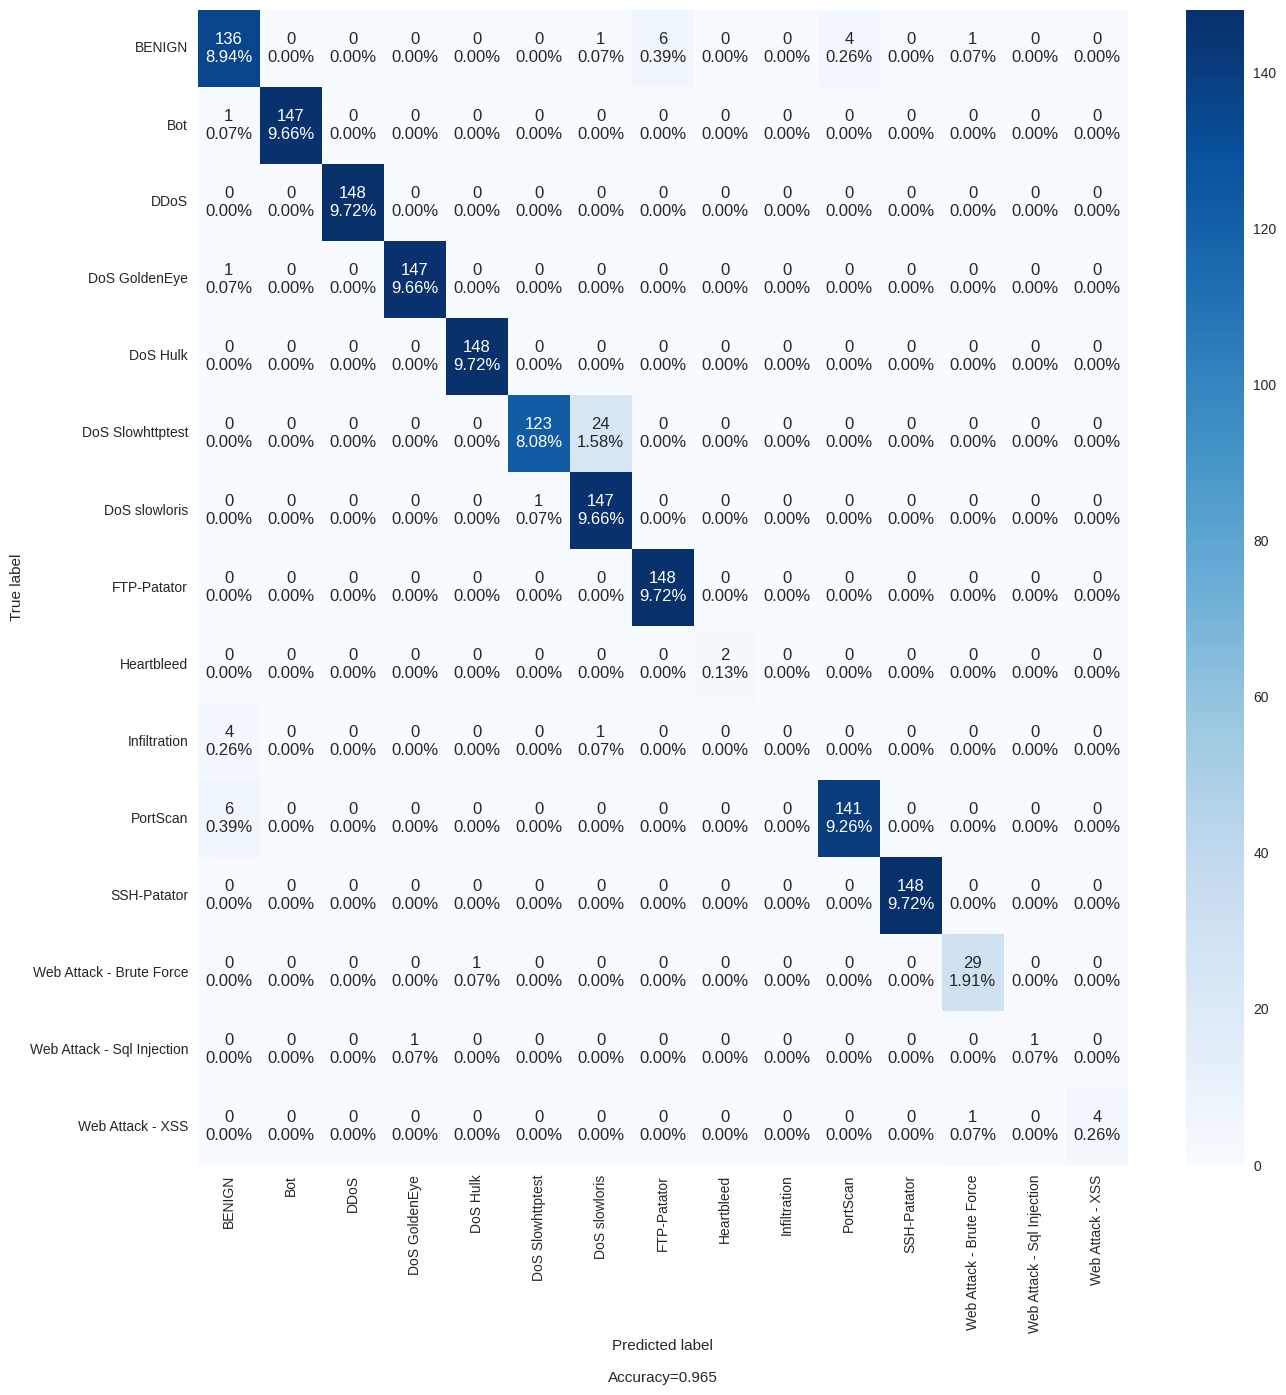

In [40]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [41]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'PortScan']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.979076,0.878449
1,PRECISION,0.980798,0.818985
2,RECALL,0.979076,0.878449
3,F1 SCORE,0.978956,0.841073


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



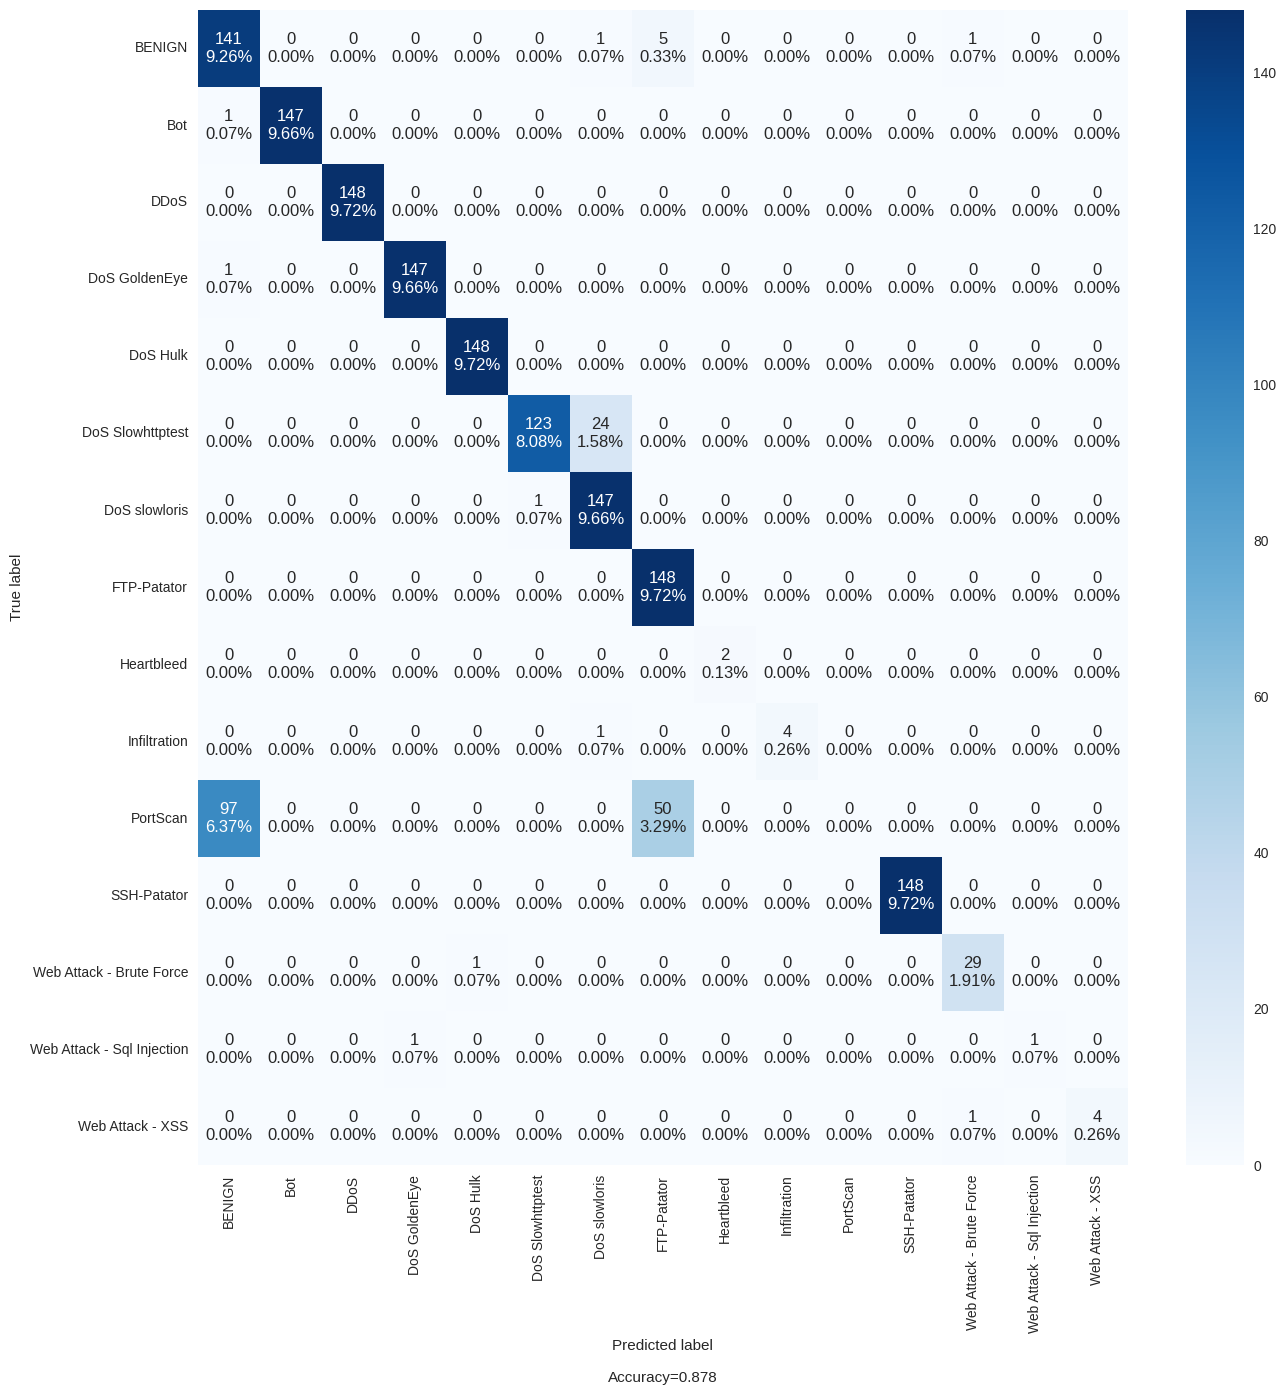

In [42]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [43]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'SSH-Patator']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.972349,0.870565
1,PRECISION,0.973981,0.857069
2,RECALL,0.972349,0.870565
3,F1 SCORE,0.972184,0.856765


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



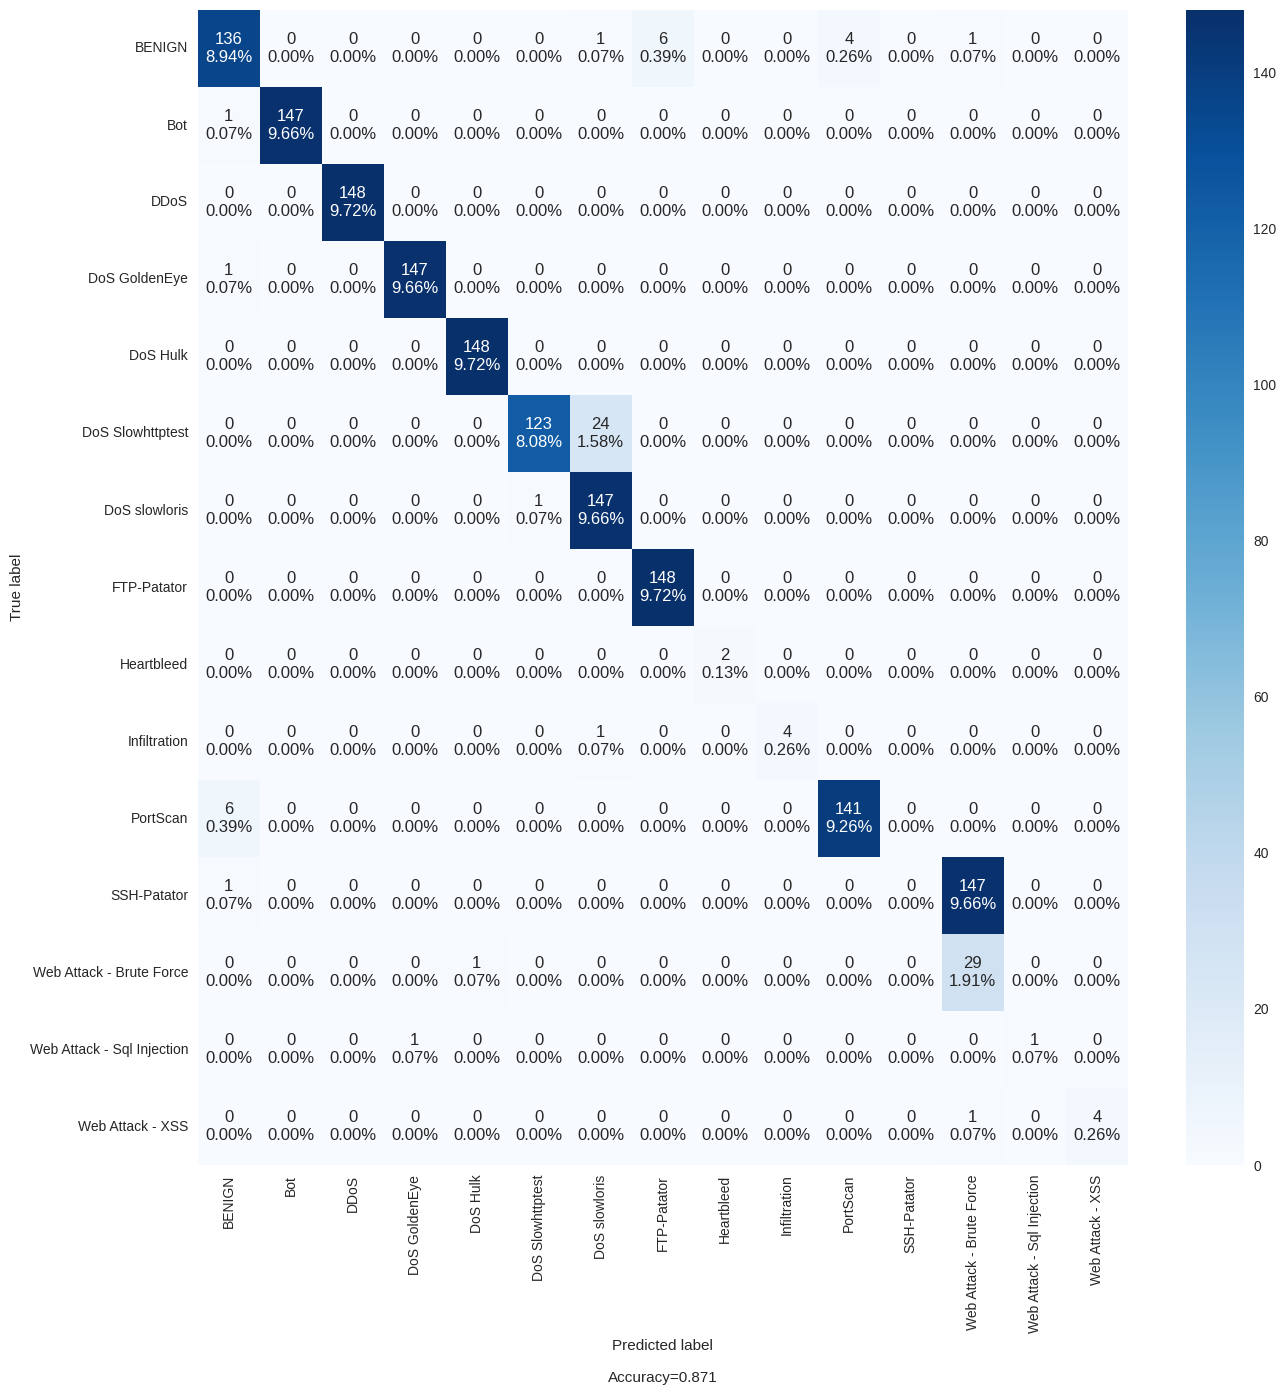

In [44]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [45]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - Brute Force']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.973852,0.948095
1,PRECISION,0.975273,0.934921
2,RECALL,0.973852,0.948095
3,F1 SCORE,0.973714,0.939650


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



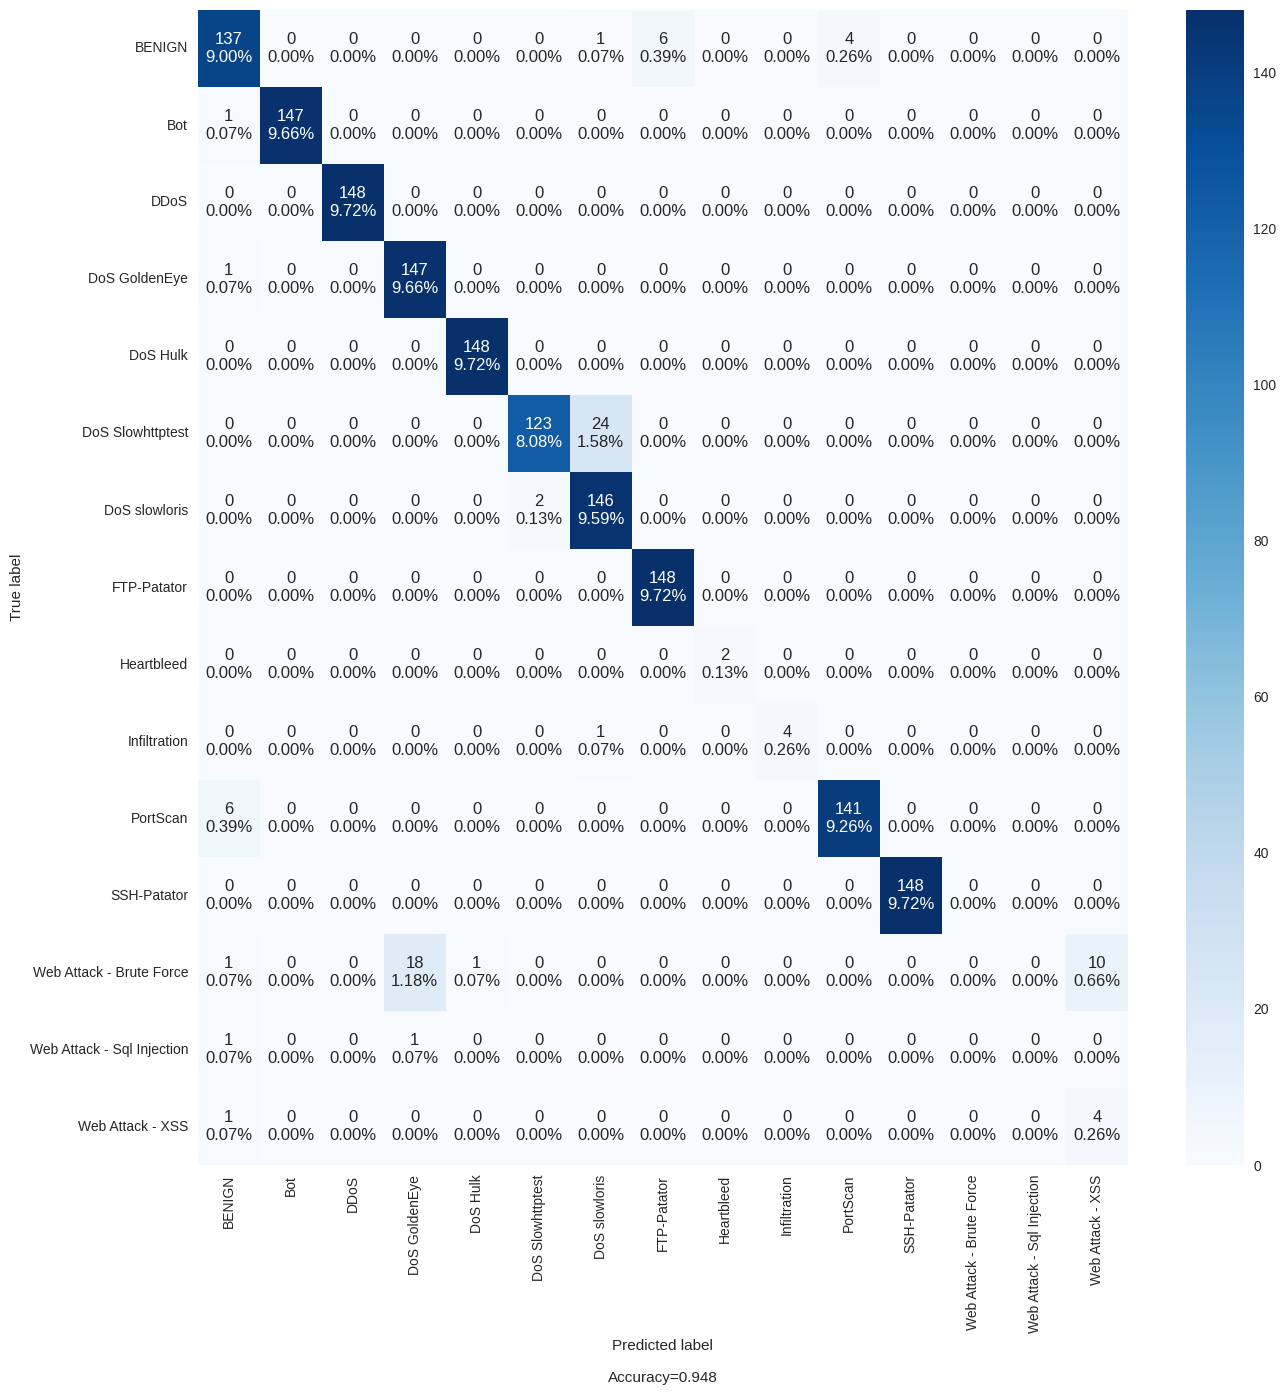

In [46]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [47]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - Sql Injection']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.974659,0.966491
1,PRECISION,0.976149,0.967533
2,RECALL,0.974659,0.966491
3,F1 SCORE,0.974519,0.965692


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



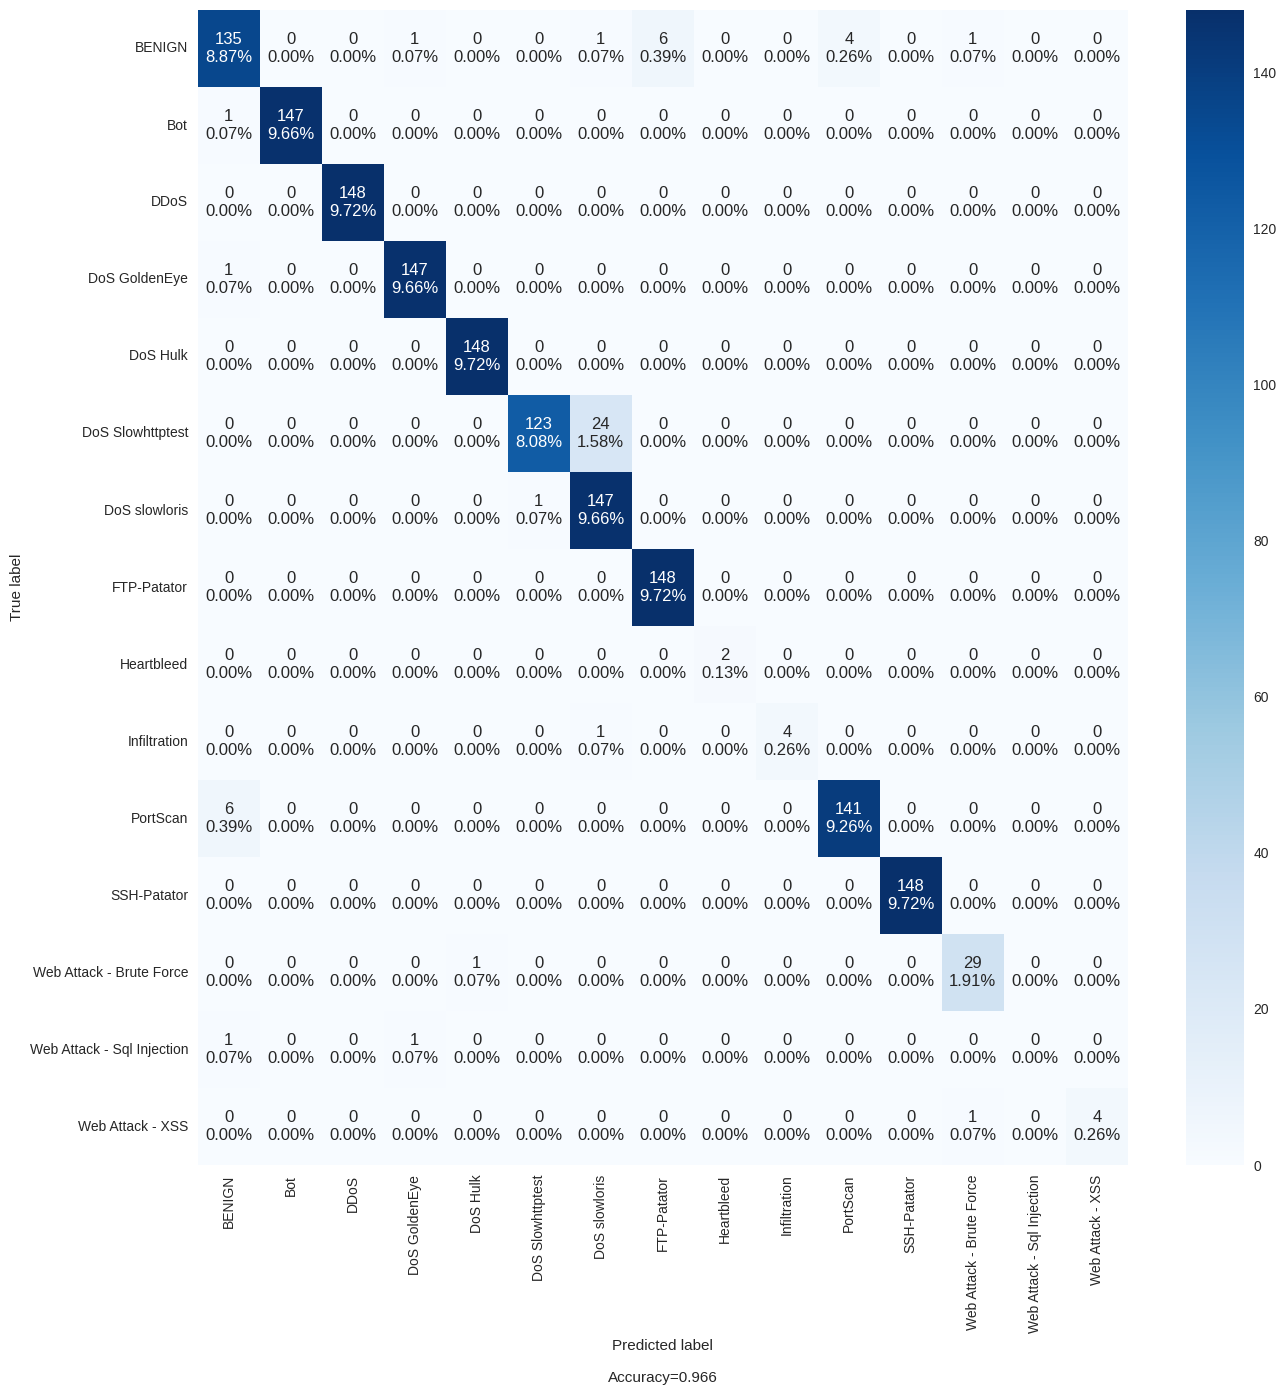

In [48]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))

In [49]:
y_train_attack = y_train.reset_index(drop=True)
y_train_attack = y_train_attack[y_train_attack != 'Web Attack - XSS']
X_train_attack = X_train.reset_index(drop=True)
X_train_attack = X_train_attack.iloc[y_train_attack.index]
ebm.fit(X_train_attack, y_train_attack)
y_predicted_train = ebm.predict(X_train_attack)
y_predicted_test = ebm.predict(X_test)
performanceMetricsDFWeighted(metrics, y_train_attack, y_predicted_train, y_test, y_predicted_test, 'weighted')

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:995: UserWarning:

Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.

/home/ludotosk/anaconda3/envs/tesi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Measure,Train,Test
0,ACCURACY,0.975268,0.965834
1,PRECISION,0.976779,0.965122
2,RECALL,0.975268,0.965834
3,F1 SCORE,0.975122,0.964037


/tmp/ipykernel_191651/374596775.py:3: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



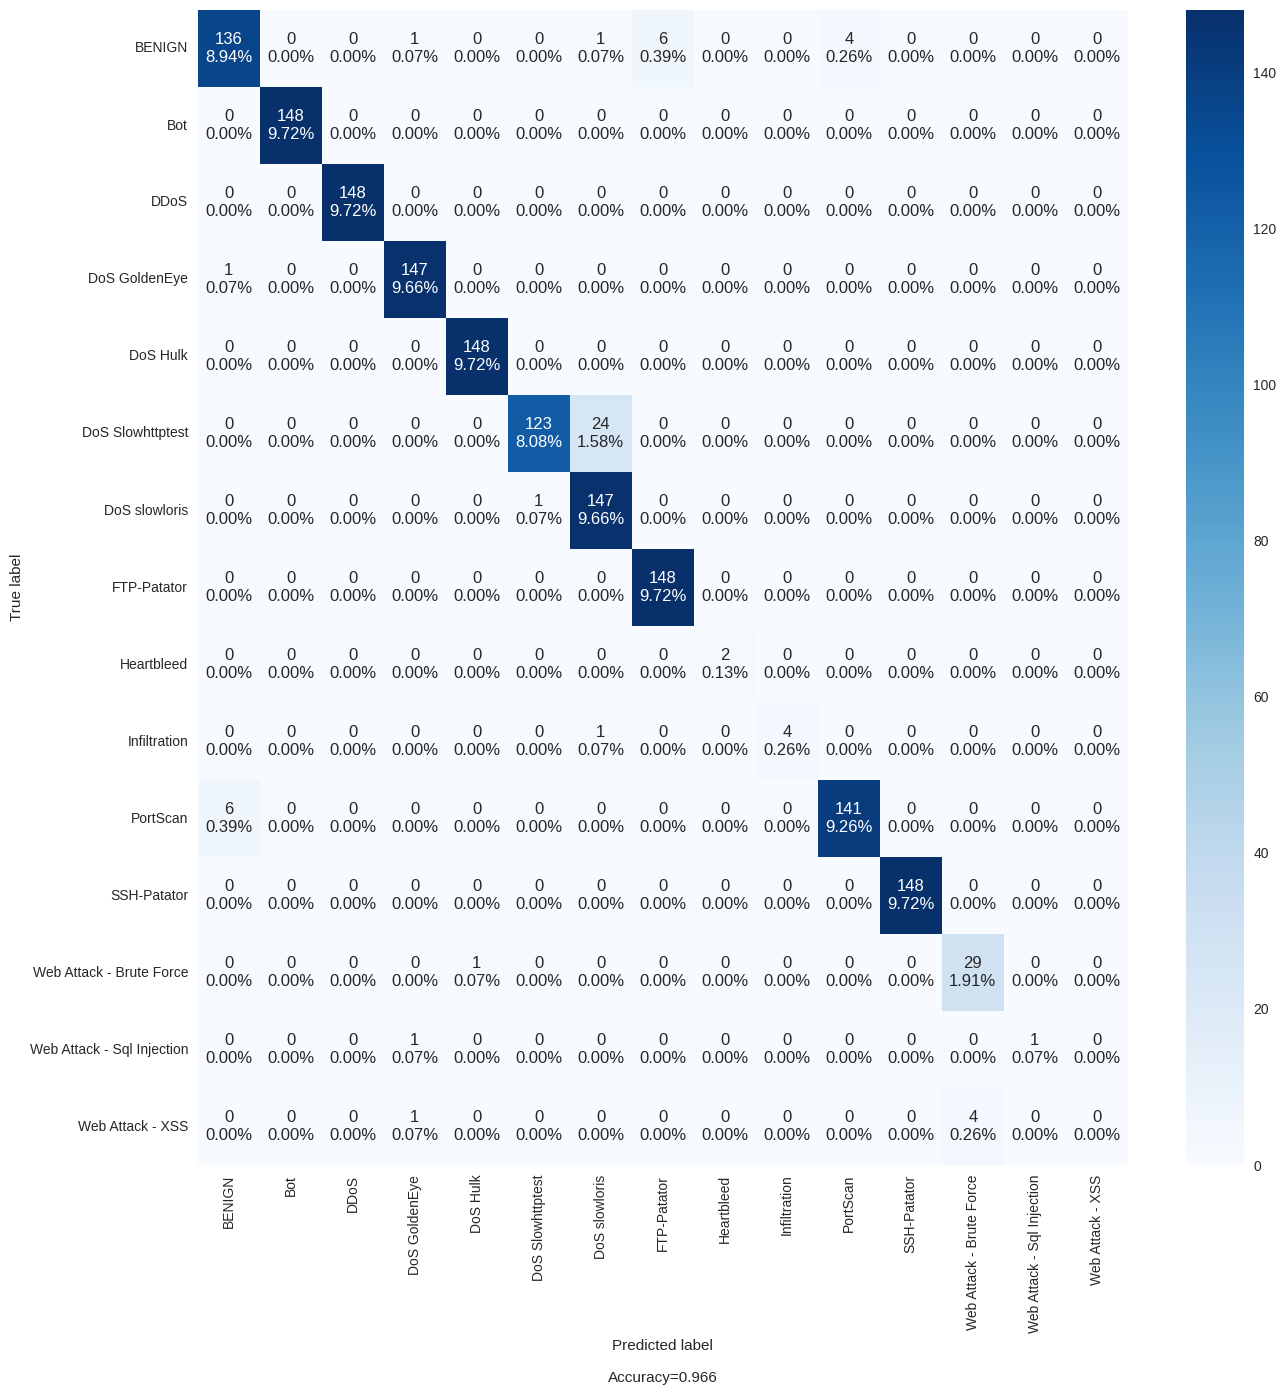

In [50]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
categories = pd.unique(classes)
make_confusion_matrix(cf, 
                      categories=categories,
                      cmap='Blues',
                      figsize=(15,15))